# Image Retrieval with Neural Codes

In this task, we are trying the approach proposed in [1], meaning we are using the representations learned by a ConvNet for image retrieval. In particular, we are going to 


1.   Train and evaluate a ConvNet on an image dataset.
2.   Compute the outputs of intermediate layers for a new image dataset, which has not been used during training. These values serve as a representation, so-called *neural codes* for the new images.
3.   Use the neural codes for image retrieval, by comparing the Euclidean distances between the codes of a query image and the remaining images.
4.   Evaluate results both qualitatively and in terms of *mean average precision*.

[1] *Artem Babenko, Anton Slesarev, Alexandr Chigorin, Victor Lempitsky, "Neural Codes for Image Retrieval"*, https://arxiv.org/abs/1404.1777.


In [1]:
%matplotlib inline

import os
import multiprocessing
import shutil
from google.colab import drive

import numpy as np
import pickle

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Input, Dense, Conv2D, MaxPooling2D, ReLU, Dropout, Reshape, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras import losses, optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import relu

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time

num_train_classes = 190

Using TensorFlow backend.


# Mount Google Drive
We will save our model there, in the folder deeplearning2020_ass2_task1.
**The model is rather big, so please make sure you have about 1 GB of space in your Google Drive.** 

In [2]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass2_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Tiny Imagenet
Tiny Imagenet is small subset of the original Imagenet dataset (http://www.image-net.org/), which is one of the most important large scale image classification datasets.
Tiny Imagenet has 200 classes, and contains 500 training examples for each class, i.e. 100,000 training examples in total. The images are of dimensions 64x64. 
**Note: You will need to re-download the data, when your Colab session has been disconnected (i.e. re-evaluate this cell).**

In [3]:
# get tiny imagenet
if not os.path.isdir('tiny-imagenet-200'):
  start_time = time.time()
  if not os.path.isfile('tiny-imagenet-200.zip'):
    ! wget "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
  ! unzip -q tiny-imagenet-200.zip -d .
  print("Unzipped.")
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found folder tiny-imagenet-200')

--2020-05-25 21:09:14--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  90.8MB/s    in 2.6s    

2020-05-25 21:09:16 (90.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Unzipped.
Elapsed time: 16.842495441436768 seconds.


# Load Tiny Imagenet
We are going to use the official training set of Tiny Imagenet for our purposes, and ignore the official validation and test sets. 
We will use 190 classes (95,000 images) of the official training set to make new training, validation and test sets, containing 76,000, 9,500, and 9,500 images, respectively. The remaining 10 classes (5,000 images) will never have been seen during training, and will constitute an *out-of-domain* (ood) set.
The ood set will be used for image retrieval.
Thus, we'll have:

*   Train data: 76,000 images, 64x64x3 pixels, classes 0-189
*   Validation data: 9,500 images, 64x64x3 pixels, classes 0-189
*   Test data: 9,500 images, 64x64x3 pixels, classes 0-189
*   Out-of-domain data: 5000 images, 64x64x3 pixels, **classes 190-199**


In [4]:
def load_imagenet(num_train_classes):
  def load_class_images(class_string, label):
    """
    Loads all images in folder class_string.

    :param class_string: image folder (e.g. 'n01774750')
    :param label: label to be assigned to these images
    :return class_k_img: (num_files, width, height, 3) numpy array containing
                         images of folder class_string
    :return class_k_labels: numpy array containing labels
    """
    class_k_path = os.path.join('tiny-imagenet-200/train/', class_string, 'images')
    file_list = sorted(os.listdir(class_k_path))

    dtype = np.uint8

    class_k_img = np.zeros((len(file_list), 64, 64, 3), dtype=dtype)
    for l, f in enumerate(file_list):
      file_path = os.path.join('tiny-imagenet-200/train/', class_string, 'images', f)
      img = mpimg.imread(file_path)
      if len(img.shape) == 2:
        class_k_img[l, :, :, :] = np.expand_dims(img, -1).astype(dtype)
      else:
        class_k_img[l, :, :, :] = img.astype(dtype)

    class_k_labels = label * np.ones(len(file_list), dtype=dtype)

    return class_k_img, class_k_labels

  # get the word description for all imagenet 82115 classes
  all_class_dict = {}
  for k, line in enumerate(open('tiny-imagenet-200/words.txt', 'r')):
    n_id, description = line.split('\t')[:2]
    all_class_dict[n_id] = description

  # this will be the description for our 200 classes
  class_dict = {}

  # we enumerate the classes according to their folder names:
  # 'n01443537' -> 0
  # 'n01629819' -> 1
  # ...
  ls_train = sorted(os.listdir('tiny-imagenet-200/train'))
  img = None
  labels = None
  ood_x = None
  ood_y = None

  # the first num_train_classes will make the training, validation, test sets
  for k in range(num_train_classes):
    # the word descritpion of the current class
    class_dict[k] = all_class_dict[ls_train[k]]
    # load images and labels for current class
    class_k_img, class_k_labels = load_class_images(ls_train[k], k)
    # concatenate all samples and labels
    if img is None:
      img = class_k_img
      labels = class_k_labels
    else:
      img = np.concatenate((img, class_k_img), axis=0)
      labels = np.concatenate((labels, class_k_labels))

  # the remaining classes are the out of domain (ood) set 
  for k in range(num_train_classes, 200):
    class_dict[k] = all_class_dict[ls_train[k]]
    class_k_img, class_k_labels = load_class_images(ls_train[k], k)
    if ood_x is None:
      ood_x = class_k_img
      ood_y = class_k_labels
    else:
      ood_x = np.concatenate((ood_x, class_k_img), axis=0)
      ood_y = np.concatenate((ood_y, class_k_labels))

  return img, labels, ood_x, ood_y, class_dict

print('Loading data...')
start_time = time.time()
train_x, train_y, ood_x, ood_y, class_dict = load_imagenet(num_train_classes)
print('Data loaded in {} seconds.'.format(time.time() - start_time))

def split_data(x, y, N):
  x_N = x[0:N, ...]
  y_N = y[0:N]
  x_rest = x[N:, ...]
  y_rest = y[N:, ...]
  return x_N, y_N, x_rest, y_rest

# fix random seed
np.random.seed(42)

# shuffle
N = train_x.shape[0]
rp = np.random.permutation(N)
train_x = train_x[rp, ...]
train_y = train_y[rp]

# train/validation split 80 - 10 - 10
N_val = int(round(N * 0.1))
N_test = int(round(N * 0.1))
val_x, val_y, train_x, train_y = split_data(train_x, train_y, N_val)
test_x, test_y, train_x, train_y = split_data(train_x, train_y, N_test)

# shuffle ood data
N_ood = ood_x.shape[0]
rp = np.random.permutation(N_ood)
ood_x = ood_x[rp, ...]
ood_y = ood_y[rp]

# convert all data into float32
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)
val_x = val_x.astype(np.float32)
val_y = val_y.astype(np.float32)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(np.float32)
ood_x = ood_x.astype(np.float32)
ood_y = ood_y.astype(np.float32)

# normalize
train_x /= 255.
val_x /= 255.
test_x /= 255.
ood_x /= 255.

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(ood_x.shape)

Loading data...
Data loaded in 47.88178586959839 seconds.
(76000, 64, 64, 3)
(9500, 64, 64, 3)
(9500, 64, 64, 3)
(5000, 64, 64, 3)


# Show Some Images

train 30860: comic book



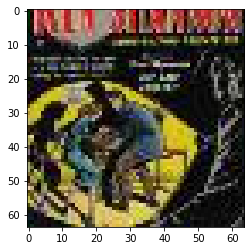

train 21145: teapot



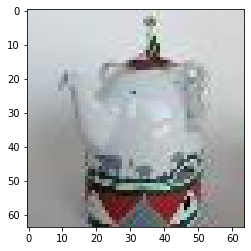

train 37042: bathtub, bathing tub, bath, tub



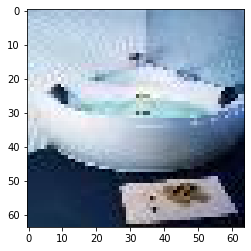

validation 3224: bullet train, bullet



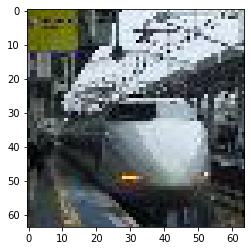

validation 7735: tarantula



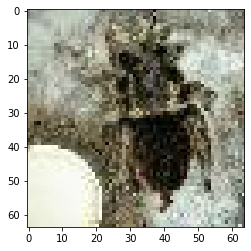

validation 7974: sea cucumber, holothurian



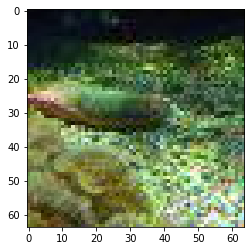

test 7810: Egyptian cat



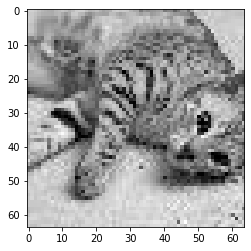

test 5597: snail



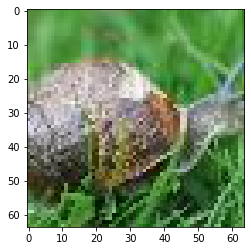

test 5693: plate



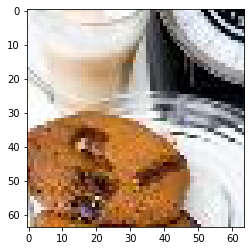

out of domain 737: coral reef



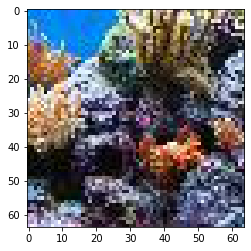

out of domain 4062: cliff, drop, drop-off



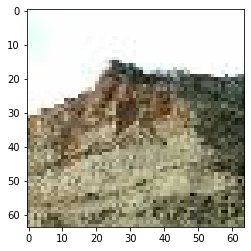

out of domain 1223: pizza, pizza pie



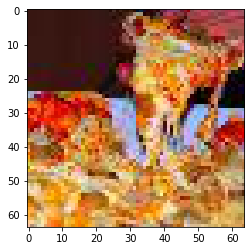

In [5]:
def show_random_images(img, labels, K, qualifier):
  for k in range(K):
    idx = np.random.randint(0, img.shape[0])
    print("{} {}: {}".format(qualifier, idx, class_dict[labels[idx]]))
    plt.imshow(img[idx,:,:,:])
    plt.show()

show_random_images(train_x, train_y, 3, 'train')
show_random_images(val_x, val_y, 3, 'validation')
show_random_images(test_x, test_y, 3, 'test')
show_random_images(ood_x, ood_y, 3, 'out of domain')


# Make and Train Model

Implement a convolutional neural network similar to the one in [1].
We will simplify the architecture a bit, since we are dealing with Tiny Imagenet here, and since we would have trouble training the original model in Colab:

1.   For the first convolutional layer, use a kernel size of 4 and stride 1, but still 96 filters.
2.   For the *hidden* fully connected layers, use 2048 units, instead of 4096.

Otherwise, use the same architecture as in [1].

Some hints and remarks:

*   Use 'same' padding for all convolutional and pooling layers.
*   For the last layer, use *num_train_classes* (defined above) units.
*   For all layers use *relu* activation functions, except for the last layer, where you should use the *softmax* activation.
*   Apply dropout with dropout rate 0.5 before the two hidden fully connected layers.
*   Train the model with the Adam optimizer, using a learning rate of 0.0001 and set *amsgrad=True*.
*   Use early stopping [2] by calling model.fit(...) with argument *callbacks=[early_stopping_callback]*. The early_stopping_callback is already defined below. You'll need to provide the validation set as argument *validation_data* in model.fit(...).
*   Train using *crossentropy* loss. You can use 
losses.sparse_categorical_crossentropy, since labels are not encoded in one-hot encoding.
*   Use a *batch size* of 100.
*   Train for maximal 100 epochs (early stopping will likely stop training much earlier).
*   During training, measure *accuracy* and *top-5 accuracy*. You can use *sparse_top_k_categorical_accuracy*, since labels are not encoded in one-hot encoding.

[2] https://en.wikipedia.org/wiki/Early_stopping


In [6]:
def make_model():

  # keras model
  model = Sequential()

  # Make your model here
  # ...

  input_shape = (64, 64, 3)

  dropout_rate = 0.5

  model.add(Conv2D(filters=96, kernel_size=4, activation=None, input_shape=input_shape, padding='same'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(Activation(relu))

  model.add(Conv2D(filters=192, kernel_size=5, activation=None, padding='same'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(Activation(relu))

  model.add(Conv2D(filters=288, kernel_size=3, activation=None, padding='same'))
  model.add(Activation(relu))

  model.add(Conv2D(filters=288, kernel_size=3, activation=None, padding='same'))
  model.add(Activation(relu))

  model.add(Conv2D(filters=256, kernel_size=3, activation=None, padding='same'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(Flatten())
  model.add(Activation(relu))

  if dropout_rate is not None:
    model.add(Dropout(rate=dropout_rate))
  model.add(Dense(2048, activation=None))
  model.add(Activation(relu))

  if dropout_rate is not None:
    model.add(Dropout(rate=dropout_rate))
  model.add(Dense(2048, activation=None))
  model.add(Activation(relu))

  model.add(Dense(num_train_classes, activation='softmax'))

  # ...

  return model

def make_model_and_train():

  if not os.path.isdir(base_path):
    raise AssertionError('No folder base_path. Please run cell "Mount google drive" above.')

  model = make_model()
  model.summary()

  early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          min_delta=0,
                                                          patience=0,
                                                          verbose=1, 
                                                          mode='auto')

  # run training here
  # ...

  adam = optimizers.Adam(learning_rate=0.0001, amsgrad=True)
  model.compile(loss=losses.sparse_categorical_crossentropy, optimizer=adam, metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
  model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), batch_size=100, epochs=100, verbose=1, callbacks=[early_stopping_callback])
  
  # ...

  # save model to google drive
  model.save(os.path.join(base_path, 'model.h5'))

  tf.keras.backend.clear_session()

#
make_model_and_train()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        4704      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       460992    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 192)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       4

# Evaluate Model

Evaluate the crossentropy, classification accuracy and top-5 classification accuracy on the train, validation and test sets.

In [7]:
model = load_model(os.path.join(base_path, 'model.h5'))

# ...
model.evaluate(x=train_x, y=train_y, batch_size=250)
model.evaluate(x=val_x, y=val_y, batch_size=250)
model.evaluate(x=test_x, y=test_y, batch_size=250)
# ...

38/38 [==============================] - 2s 43ms/step - loss: 2.8915 - accuracy: 0.3500 - sparse_top_k_categorical_accuracy: 0.6134


[2.891467809677124, 0.3499999940395355, 0.6133683919906616]

# Image Retrieval

We are now using the trained model for image retrieval on the out-of-domain dataset ood_x. 
We are considering, in turn, single images from *ood_x* as query image, and the remaining 4,999 images as retrieval database.
The task of image retrieval (IR) is to find the *K* most similar images to the query image.
In [1], similarity is defined as Euclidean distance between l2-normalised neural codes, where neural codes are simply the outputs of particular ConvNet layers.

For each of the *3* layers which were considered in [1], perform the following steps:

1.  Perform image retrieval for the first *10* images from *ood_x*. Retrieve the *K=5* most similar images for each query. Show the query image and the retrieved images next to each other, and mark the retrieved images which have the same class (stored in *ood_y*) as the query image. See Fig. 2 and 3 in [1] for examples (your results do not need to look precisely like in the paper. E.g., you can use *imshow* and *subplot*, and simply use *print* for the labels). 

2.   Compute and report the *mean average precision* (mAP), by computing  the *average precision* (AP) for each image in *ood_x*, and taking the mean AP over all 5,000 images.

Hints:

*   Make sure that the model is properly loaded, see previous cell.
*   To obtain the neural codes, you can use the provided function eval_layer_batched(model, layer_name, ood_x, 100). It evaluates the layer with name *layer_name* for the whole ood_x. For example, if the layer contains 1024 units, this function will return a numpy array of size 5000x1024, with rows corresponding to images and columns to units.
*   The AP is defined as follows.
  *   Let *TP* be the number of *true positives*, that is, the number of retrieved images which have the *same* label as the query image.
  *   Let *FP* be the number of *false positives*, that is, the number of retrieved images which have a *different* label than the query image.
  *   Let *FN* be the number of *false negatives*, that is, the number of *non-retrieved* images, which have the *same* label as the query image.
  *   The *precision* of an IR algorithm is defined as *precision* := TP / (TP + FP).   
  *   The *recall* is defined as *recall* := TP / (TP + FN).
  *   To better understand precision and recall, figure a haystack with some needles in it. Precision will be high if you carefully select very few objects, where you are sure that these are needles. But recall will be low then. Recall will be high if you just grab and return the whole haystack. But precision will be low then. Thus, precision and recall are (usually) opposed to each other and represent a trade-off.
  * This trade-off can typically be governed by some hyper-parameter, in our case *K*, the number of retrieved images. For large *K*, we have large recall but low precision, for small *K* we have higher precision but low recall.
  * The trade-off can be inspected by looking at the precision-recall curve. The AP is defined as area under the precision-recall curve.
  *   Fortunately, an estimator of AP is already implemented for you in the function *average_precision*. It takes two arguments:
     *  sorted_class_vals: list of **class values** of the 4,999 other images, sorted according to closeness to the query image (closest first, most distant last).
     *  true_class: the class values of the query image.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        4704      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       460992    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 192)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       4

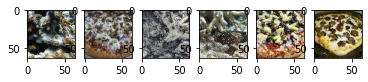

True class:
coral reef

Top 5 predicted:
pizza, pizza pie
coral reef
coral reef
pizza, pizza pie
pizza, pizza pie

Average precision 0.21599195094290144



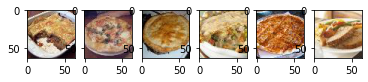

True class:
potpie

Top 5 predicted:
pizza, pizza pie
potpie
potpie
pizza, pizza pie
meat loaf, meatloaf

Average precision 0.3051122386374311



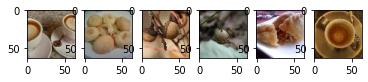

True class:
espresso

Top 5 predicted:
potpie
acorn
acorn
potpie
espresso

Average precision 0.2984826770239698



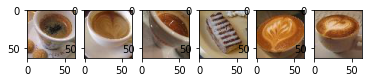

True class:
espresso

Top 5 predicted:
espresso
espresso
meat loaf, meatloaf
espresso
espresso

Average precision 0.28353936877661573



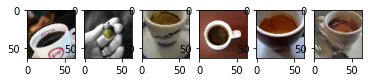

True class:
espresso

Top 5 predicted:
acorn
espresso
espresso
espresso
espresso

Average precision 0.5374943001236848

mAP = 0.28694868320472794






dense


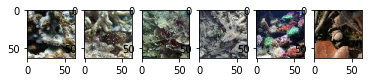

True class:
coral reef

Top 5 predicted:
coral reef
coral reef
coral reef
coral reef
acorn

Average precision 0.20536837835827906



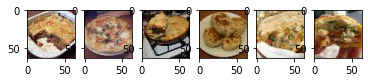

True class:
potpie

Top 5 predicted:
pizza, pizza pie
potpie
potpie
potpie
meat loaf, meatloaf

Average precision 0.3565022195269445



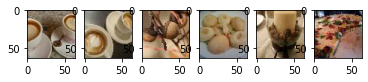

True class:
espresso

Top 5 predicted:
espresso
acorn
potpie
acorn
pizza, pizza pie

Average precision 0.28522379842693196



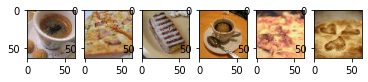

True class:
espresso

Top 5 predicted:
potpie
meat loaf, meatloaf
espresso
pizza, pizza pie
potpie

Average precision 0.22974388107269225



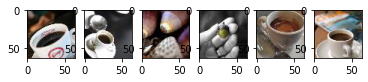

True class:
espresso

Top 5 predicted:
espresso
acorn
acorn
espresso
espresso

Average precision 0.6152947374240669

mAP = 0.3177590923508081






dense_1


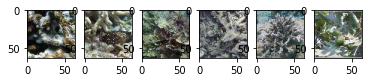

True class:
coral reef

Top 5 predicted:
coral reef
coral reef
coral reef
coral reef
acorn

Average precision 0.2752032996657377



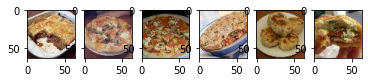

True class:
potpie

Top 5 predicted:
pizza, pizza pie
pizza, pizza pie
potpie
potpie
meat loaf, meatloaf

Average precision 0.28185350192572645



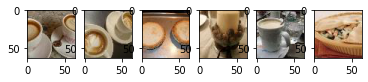

True class:
espresso

Top 5 predicted:
espresso
potpie
acorn
espresso
potpie

Average precision 0.36323975465579594



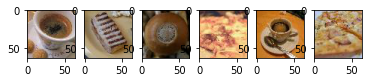

True class:
espresso

Top 5 predicted:
meat loaf, meatloaf
acorn
pizza, pizza pie
espresso
potpie

Average precision 0.23297317902406375



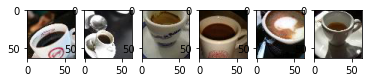

True class:
espresso

Top 5 predicted:
espresso
espresso
espresso
espresso
espresso

Average precision 0.726133663811999

mAP = 0.3448747012098237


In [8]:
model.summary()

def get_layer_functor(model, layer_name):
  inp = model.input 
  output =  model.get_layer(layer_name).output
  return K.function([inp], [output])

def eval_layer(x, layer_functor):
  return layer_functor(x)[0]

def eval_layer_batched(model, layer_name, x, batch_size):
  layer_functor = get_layer_functor(model, layer_name)
  idx = 0
  ret_vals = None
  while idx < x.shape[0]:
    if idx + batch_size > x.shape[0]:
      batch_x = x[idx:, ...]
    else:
      batch_x = x[idx:(idx+batch_size), ...]

    batch_vals = eval_layer(batch_x, layer_functor)
    if ret_vals is None:
      ret_vals = batch_vals
    else:
      ret_vals = np.concatenate((ret_vals, batch_vals), 0)

    idx += batch_size
  return ret_vals

def average_precision(sorted_class_vals, true_class):
  ind = sorted_class_vals == true_class
  num_positive = np.sum(ind)
  cum_ind = np.cumsum(ind).astype(np.float32)
  enum = np.array(range(1, len(ind)+1)).astype(np.float32)
  return np.sum(cum_ind * ind / enum) / num_positive

# ...

for layer_name in ['flatten', 'dense', 'dense_1']:

  print('\n'*5)
  print(layer_name)

  neural_codes = eval_layer_batched(model, layer_name, ood_x, 100) 

  # normalize neural codes
  neural_codes /= np.sqrt(np.sum(neural_codes**2, 1, keepdims=True))
  # min Euclidean distance <=> max inner product
  similarities = np.matmul(neural_codes, np.transpose(neural_codes))

  for k in range(5):
    sorted_idx = list(reversed(np.argsort(similarities[k,:])))
    sorted_idx = sorted_idx[1:]

    plt.subplot(1, 6, 1)
    plt.imshow(ood_x[k])
    for l in range(5):
      plt.subplot(1, 6, 2 + l)
      plt.imshow(ood_x[sorted_idx[l]])
    plt.show()  

    print("True class:")
    print(class_dict[ood_y[k]])
    print("Top 5 predicted:")
    print(''.join([class_dict[ood_y[i]] for i in sorted_idx[:5]]))  
    print("Average precision {}".format(average_precision(ood_y[sorted_idx], ood_y[k])))
    print()

  N_mAP = ood_x.shape[0]
  mAP = 0.0
  for k in range(N_mAP):
    sorted_idx = list(reversed(np.argsort(similarities[k,:])))
    sorted_idx = sorted_idx[1:]
    mAP += average_precision(ood_y[sorted_idx], ood_y[k])
  mAP /= N_mAP

  print('mAP = {}'.format(mAP))

# ...
  